In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generic Libraries
import numpy as np
import pandas as pd

# Pre-processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score

# Feature Importance Calculation
from sklearn.inspection import permutation_importance
import shap

In [3]:
positive_samples_data = '../data/churn_modeling/churn_prediction_positive_samples.csv'
negative_samples_data = '../data/churn_modeling/churn_prediction_negative_samples.csv'

In [4]:
positive_samples_df = pd.read_csv(positive_samples_data)
negative_samples_df = pd.read_csv(negative_samples_data)

In [5]:
data = pd.concat((positive_samples_df, negative_samples_df))

In [6]:
data = data.dropna()

In [7]:
X = data.drop('churned', axis = 1)
y = data['churned']

## Additional Feature Engineering

### Convert Minimum Policy Date to Ordinal

In [8]:
X['min_policy_date'] = pd.to_datetime(X['min_policy_date'])
X['min_policy_date'] = X['min_policy_date'].apply(lambda x: x.toordinal())

### One-hot Encode the State field

In [9]:
X = pd.get_dummies(X, columns = ['state'])

## Modeling

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
param_grid = {
    'n_estimators': np.arange(100, 600, 100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(4, 9),
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid, 
    n_iter = 10,
    cv = 5,
    verbose = 2,
    random_state = 42
)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=8, max_features=log2, n_estimators=400; total time=   4.5s
[CV] END criterion=gini, max_depth=8, max_features=log2, n_estimators=400; total time=   4.5s
[CV] END criterion=gini, max_depth=8, max_features=log2, n_estimators=400; total time=   4.4s
[CV] END criterion=gini, max_depth=8, max_features=log2, n_estimators=400; total time=   4.4s
[CV] END criterion=gini, max_depth=8, max_features=log2, n_estimators=400; total time=   4.4s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400; total time=   3.8s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400; total time=   3.8s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400; total time=   3.7s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400; total time=   3.8s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400; total time=   3.7s

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([4, 5, 6, 7, 8]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': array([100, 200, 300, 400, 500])},
                   random_state=42, verbose=2)

## Performance

<Figure size 640x480 with 0 Axes>

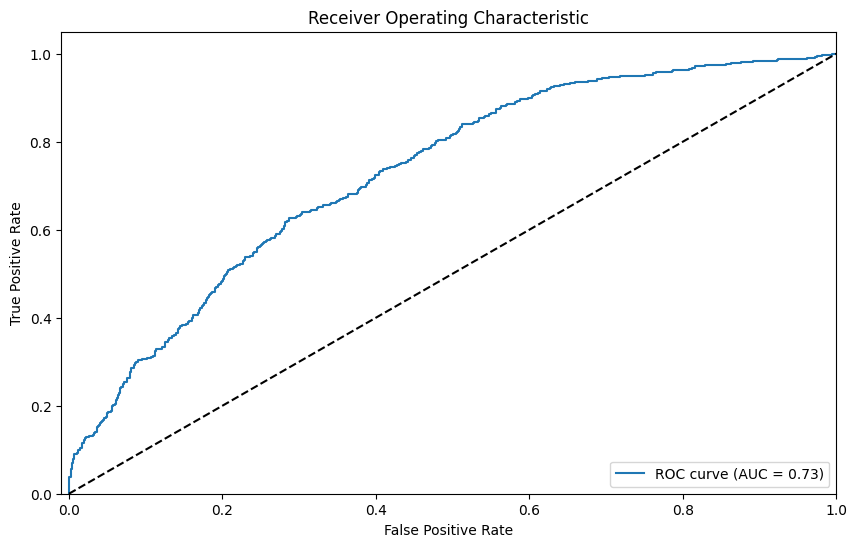

In [13]:
y_score = rf_random.best_estimator_.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()

plt.figure(figsize = (10, 6))

plt.plot(fpr, tpr, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

### **Discussion**: The ROC chart allows us to see the tradeoff between capturing positives and negatives.
### - The above results suggest that we can capture:
1. 80% of negatives; 50% of positives
2. 60% of negatives; 70% of positives
3. 50% of negatives; 80% of positives

### Since these results are much better than random, then it should be possible to predict customer churn to an extent that generates business value.

## Feature Importance

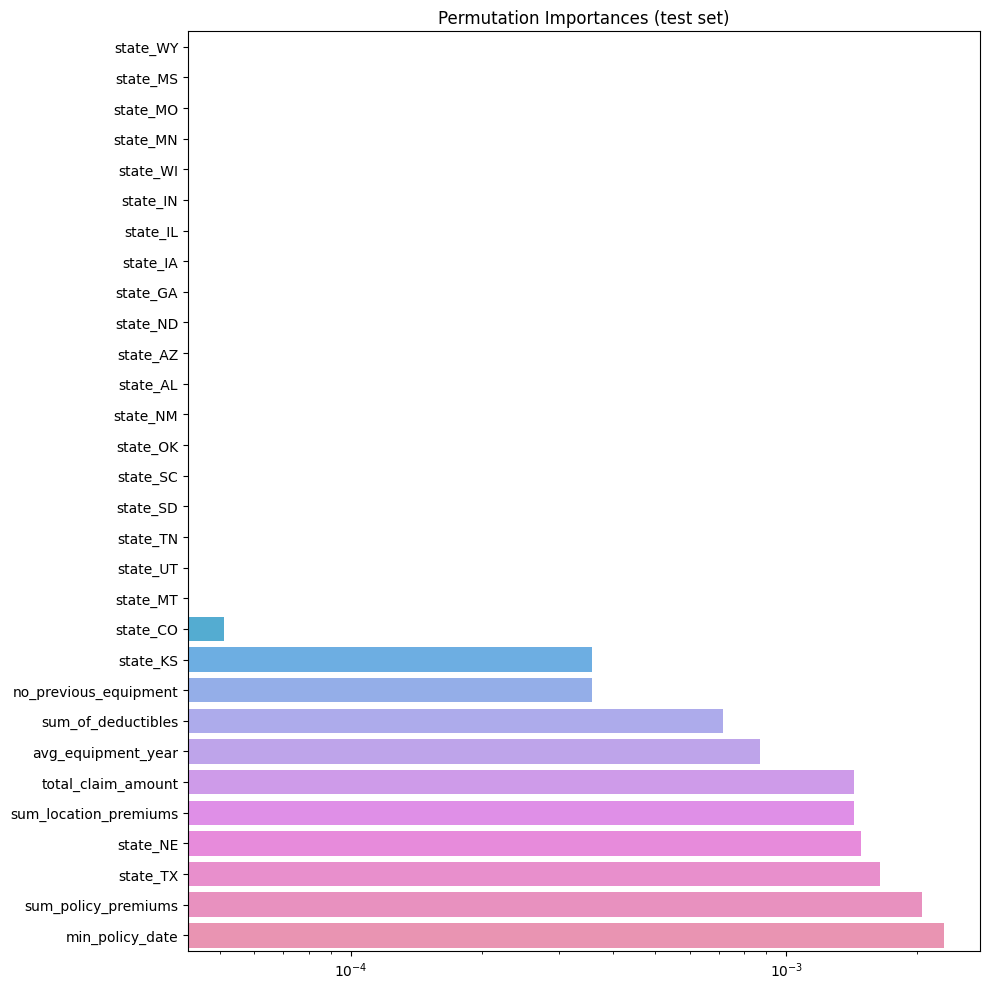

In [14]:
result = permutation_importance(rf_random, X_test, y_test, n_repeats = 10, random_state = 42, n_jobs = -1)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize = (10, 10))
sns.barplot(x = result.importances_mean[sorted_idx], y = X.columns[sorted_idx])
plt.xscale('log')
plt.title('Permutation Importances (test set)')
plt.tight_layout()
plt.show()

#### **Discussion**: The random forest model has a healthy dependence on 10 individual features.
#### The ordinal form of the first policy effective date for a given customer appears to gave the strongest bearing on whether a customer will churn or not.